In [1]:
import sys 
sys.path.append(r'/Users/kostastsampourakis/Desktop/code/Python/projects/neuralssm/src/neuralssm')
import jax # type: ignore
from jax import numpy as jnp # type: ignore
from jax import random as jr # type: ignore
import jax.scipy.stats as jss # type: ignore
from dynamax.utils.bijectors import RealToPSDBijector # type: ignore
import blackjax # type: ignore


import tensorflow_probability.substrates.jax.distributions as tfd # type: ignore

from utils import reshape_emissions
from density_models import MAF
from flax import nnx # type: ignore
from matplotlib import pyplot as plt # type: ignore
from parameters import params_from_tree, sample_ssm_params, initialize, to_train_array, log_prior, get_unravel_fn, join_trees, tree_from_params
import tensorflow_probability.substrates.jax.distributions as tfd # type: ignore
from simulation_inference import taf_sample_and_train, snl_sample_and_train, sequential_posterior_sampling
from ssm import SV
from filters import bpf

from datetime import date 
import matplotlib.pyplot as plt # type: ignore
import matplotlib_inline # type: ignore
import scienceplots # type: ignore

plt.style.use(['science', 'ieee'])
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# Define inference loop
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

## Initialize model and simulate dataset

In [3]:
num_timesteps = 100
num_mcmc_steps = 1000

state_dim = 1
emission_dim = state_dim
input_dim = 0

initial_mean = jnp.zeros(state_dim)
initial_covariance = jnp.eye(state_dim) * 1.0

dynamics_weights  = 0.91 * jnp.eye(state_dim)
dynamics_bias = jnp.zeros(state_dim)
dynamics_input_weights = jnp.zeros((state_dim, input_dim))
dynamics_covariance = jnp.eye(state_dim) * 1.0

emission_bias = jnp.zeros(emission_dim)
emission_covariance = jnp.eye(emission_dim) * 1.0
emission_beta = jnp.array([0.3])
emission_sigma = jnp.array([[2.0]]) 

# Initialize params and props
m = state_dim * (state_dim + 1) // 2
dynamics_covariance_dist = tfd.MultivariateNormalDiag(loc=jnp.zeros(m), scale_diag=jnp.ones(m))
ell = emission_dim * (emission_dim + 1) // 2
emission_sigma_dist = tfd.MultivariateNormalDiag(loc=0.3*jnp.ones(ell), scale_diag=0.1*jnp.ones(ell))

param_names = [['mean', 'cov'],
               ['weights', 'bias', 'input_weights', 'cov'],
               ['bias', 'cov', 'beta', 'sigma']]

prior_fields = [[initial_mean, initial_covariance],
                [dynamics_weights, dynamics_bias, dynamics_input_weights, dynamics_covariance_dist],
                [emission_bias, emission_covariance, emission_beta, emission_sigma_dist]]

is_constrained_tree = [[True, True], 
                       [True, True, True, False], 
                       [True, True, True, False]]

constrainers  = [[None, RealToPSDBijector],
                [None, None, None, RealToPSDBijector],
                [None, RealToPSDBijector, None, RealToPSDBijector]]

props, prior = initialize(prior_fields, param_names, constrainers)

### Sample ***true*** params and emissions

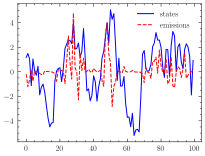

In [4]:
key, subkey1, subkey2= jr.split(jax.random.key(int(date.today().strftime("%Y%m%d"))), 3)
[true_param, example_param] = sample_ssm_params(subkey1, prior, 2)
true_param_vec = to_train_array(true_param, props)
true_param.from_unconstrained(props)
true_param_value = to_train_array(true_param, props)
svmodel = SV(state_dim, emission_dim)
states, emissions = svmodel.simulate(subkey2, true_param, num_timesteps)

plt.plot(states, c='blue', label='states')
plt.plot(emissions, label='emissions')
plt.legend()
plt.show()

In [35]:
em = jnp.concatenate([emissions, emissions], axis=1)
em.shape

(100, 2)

## Train TAF model

In [27]:
def taf_logdensity_fn(cond_params, model ,emissions, prior, lag):
    lagged_emissions = reshape_emissions(emissions, lag)
    tile_cond_params = jnp.tile(cond_params, (lagged_emissions.shape[0], 1))
    lp = -model.loss_fn(jnp.concatenate([tile_cond_params, lagged_emissions], axis=1))
    lp += log_prior(cond_params, prior)
    return lp

def snl_logdensity_fn(cond_params, model, emissions, prior, lag):
    lp = -model.loss_fn(jnp.concatenate([cond_params[None], emissions.T], axis=1))
    lp += log_prior(cond_params, prior)
    return lp


In [13]:
from simulation_inference import sequential_posterior_sampling, snl_sample_and_train, taf_sample_and_train

lag = 15
din = emission_dim
n_params = to_train_array(example_param, props).shape[0]
dcond = lag * emission_dim + n_params
reverse = True
random_order = False
batch_norm = False
dropout = False
nmades = 5
dhidden = 32
nhidden = 5

# Initialize model
taf = MAF(din, nmades, dhidden, nhidden, dcond, nnx.Rngs(0), random_order, reverse, batch_norm, dropout)
test_sv_model = SV(state_dim, emission_dim)

#### Sample parameters
num_samples = 10
num_timesteps = num_timesteps
key, subkey = jr.split(key)
params_sample = sample_ssm_params(subkey, prior, num_samples) # Here, output params are in mixed constrained/unconstrained form
                                                              # The trainable params (given in prior by dist) are unconstrained
                                                              # whereas the not-trainable params (given in prior by arrays) are constrained
                                                              # In the trainer, the cond_params are appended to the dataset and then the params are converted
                                                              # to constrained form before being passed to the model for simulation. 
dataset = []
num_rounds = 2
params_samples_allrounds = []

taf_postmodel = sequential_posterior_sampling(key = key,
                sample_and_train=taf_sample_and_train,
                model = taf,
                ssmodel=test_sv_model,
                lag=lag,
                num_rounds=num_rounds,
                num_timesteps=num_timesteps,
                num_samples=num_samples,
                num_mcmc_steps=num_mcmc_steps,
                emissions=emissions,
                logdensity_fn=taf_logdensity_fn,
                prior=prior,
                props=props,
                example_param=example_param,
                param_names=param_names,
                is_constrained_tree=is_constrained_tree,
                rw_sigma=0.1
)

# for r in range(num_rounds):
#     print(f"-Round {r}")

#     # Add previous samples to samples
#     params_samples_allrounds.append(params_sample)    

#     # Sample SSM and train TAF
#     key, subkey1, subkey2 = jr.split(key, 3)
#     key, subkey = jr.split(key)
#     model, dataset = sample_and_train(
#             key = subkey,
#             model = model,
#             ssmodel = test_sv_model,
#             params_sample = params_sample,
#             example_params = example_param, 
#             prev_dataset = dataset, 
#             lag = lag,
#             num_timesteps = num_timesteps, 
#             props = props,
#             num_epochs = 20,
#             learning_rate = 1 * 1e-4,
#             verbose=False
#         )
#     # Sample new parameters
#     print("-Sampling new parameters")

#     def taf_logdensity_fn(cond_params):
#         lagged_emissions = reshape_emissions(emissions, lag)
#         tile_cond_params = jnp.tile(cond_params, (lagged_emissions.shape[0], 1))
#         lp = -model.loss_fn(jnp.concatenate([tile_cond_params, lagged_emissions], axis=1))
#         lp += log_prior(cond_params, prior)
#         return lp

#     # Initialize MCMC chain and kernel
#     rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
#     initial_cond_params = to_train_array(sample_ssm_params(rng_key, prior, 1)[0], props)

#     taf_random_walk = blackjax.additive_step_random_walk(taf_logdensity_fn, blackjax.mcmc.random_walk.normal(0.1))
#     taf_initial_state = taf_random_walk.init(initial_cond_params)
#     taf_kernel = jax.jit(taf_random_walk.step)

#     # Run inference loop
#     rng_key, sample_key1, sample_key2 = jax.random.split(rng_key, 3)
#     taf_mcmc_states = inference_loop(sample_key1, taf_kernel, taf_initial_state, num_mcmc_steps)
#     positions = taf_mcmc_states.position[-num_samples:]

#     params_sample = []
#     print("Adding new params")
#     for cond_param in positions:
#         unravel_fn = get_unravel_fn(example_param, props)
#         unravel = unravel_fn(cond_param)
#         tree = tree_from_params(example_param)
#         new_tree = join_trees(unravel, tree, props)
#         param = params_from_tree(new_tree, param_names, is_constrained_tree)
#         params_sample.append(param)

#     # params_sample = smc_sampler(subkey2, model, props, prior, loglik, emissions, lag, num_samples, jittering=0.001)


-------- Round 0
* * * Training
* * * Sampling new parameters
* * * Adding new params
-------- Round 1
* * * Training
* * * Sampling new parameters
* * * Adding new params


In [28]:
din = emission_dim * num_timesteps
n_params = to_train_array(example_param, props).shape[0]
dcond = n_params

# Initialize model
snl = MAF(din, nmades, dhidden, nhidden, dcond, nnx.Rngs(0), random_order, reverse, batch_norm, dropout)

snl_postmodel = sequential_posterior_sampling(key = key,
                sample_and_train=snl_sample_and_train,
                model = snl,
                ssmodel=test_sv_model,
                lag=lag,
                num_rounds=num_rounds,
                num_timesteps=num_timesteps,
                num_samples=num_samples,
                num_mcmc_steps=num_mcmc_steps,
                emissions=emissions,
                logdensity_fn=snl_logdensity_fn,
                prior=prior,
                props=props,
                example_param=example_param,
                param_names=param_names,
                is_constrained_tree=is_constrained_tree,
                rw_sigma=0.1
                )

-------- Round 0
* * * Training
* * * Sampling new parameters
* * * Adding new params
-------- Round 1
* * * Training
* * * Sampling new parameters
* * * Adding new params


In [6]:
# target_param_list = []
# for param in params_samples_allrounds[0]:
#     param.to_unconstrained(props)
#     target_param_list.append(param.emissions.sigma.value)
# cond_params = jnp.array(target_param_list).flatten()
# cond_params = jnp.sort(cond_params)

# log_density_values = vmap(lambda param: logdensity_fn(model, prior, param, emissions, lag))(cond_params[:, None])
# log_likelihood_values = vmap(lambda param: loglik(model, param, emissions, lag))(cond_params[:, None])

# log_density_values = log_density_values - jnp.min(log_density_values)
# log_density_values = log_density_values / jnp.max(log_density_values)
# log_likelihood_values = log_likelihood_values - jnp.min(log_likelihood_values)
# log_likelihood_values = log_likelihood_values / jnp.max(log_likelihood_values)

# plt.plot(cond_params, log_density_values, label='log density')
# plt.plot(cond_params, log_likelihood_values, label='loglik')
# plt.vlines(cond_params, 0, 1, color='blue', alpha=0.02)
# plt.vlines(RealToPSDBijector().inverse([true_param_value]), 0, 1, color='red', label='True value', linestyle='--', alpha=0.2)
# plt.legend()
# plt.show()

# print('argmax loglik', RealToPSDBijector()(cond_params[None, jnp.argmax(log_likelihood_values)]))
# print('argmax logdensity', RealToPSDBijector()(cond_params[None, jnp.argmax(log_density_values)]))
# print('true value', true_param_value)

### BPF

In [7]:
# sigmas = []
# params_list = []
# for param in params_samples_allrounds[0]:
#     param.from_unconstrained(props)
#     params_list.append(param)
#     sigmas.append(param.emissions.sigma.value)
# sigmas = jnp.array(sigmas).flatten()
# # thetas = jnp.sort(thetas)
# # BPF
# num_particles = 1000
# num_iters = 10
# lls = []
# for param in params_list:
#     ll_avg = 0.0
#     for i in range(num_iters):
#         _, ll_i = bpf(param, svmodel, emissions, num_particles, key)
#         ll_avg += ll_i / num_iters
#     lls.append(ll_avg)
# lls = jnp.array(lls)

# plt.scatter(sigmas, lls)
# plt.vlines(true_param_value, jnp.min(lls), jnp.max(lls), color='red', label='true')
# plt.show()

# print('BPF argmax', sigmas[jnp.argmax(lls)])
# print('true value', true_param_value)

## Posterior Inference

In [8]:
num_particles = 10000 # Number of particles for BPF

# Define the log-density function
def bpf_logdensity_fn(cond_params):
    unravel_fn = get_unravel_fn(example_param, props)
    unravel = unravel_fn(cond_params)
    tree = tree_from_params(example_param)
    new_tree = join_trees(unravel, tree, props)
    params = params_from_tree(new_tree, param_names, is_constrained_tree)
    params.from_unconstrained(props)
    _, lp = bpf(params, test_sv_model, emissions, num_particles, key)
    lp += log_prior(cond_params, prior)
    return jnp.mean(lp)

def taf_logdensity_fn(cond_params):
    lagged_emissions = reshape_emissions(emissions, lag)
    tile_cond_params = jnp.tile(cond_params, (lagged_emissions.shape[0], 1))
    lp = -model.loss_fn(jnp.concatenate([tile_cond_params, lagged_emissions], axis=1))
    lp += log_prior(cond_params, prior)
    return lp

# Initialize MCMC chain and kernel
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
initial_cond_params = to_train_array(sample_ssm_params(rng_key, prior, 1)[0], props)

rw_sigma = 0.1
taf_random_walk = blackjax.additive_step_random_walk(taf_logdensity_fn, blackjax.mcmc.random_walk.normal(rw_sigma))
bpf_random_walk = blackjax.additive_step_random_walk(bpf_logdensity_fn, blackjax.mcmc.random_walk.normal(rw_sigma))

taf_initial_state = taf_random_walk.init(initial_cond_params)
taf_kernel = jax.jit(taf_random_walk.step)

bpf_initial_state = bpf_random_walk.init(initial_cond_params)
bpf_kernel = jax.jit(bpf_random_walk.step)

# Define inference loop
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

# Run inference loop
rng_key, sample_key1, sample_key2 = jax.random.split(rng_key, 3)
taf_mcmc_states = inference_loop(sample_key1, taf_kernel, taf_initial_state, num_mcmc_steps)
bpf_mcmc_states = inference_loop(sample_key2, bpf_kernel, bpf_initial_state, num_mcmc_steps)

## Output

### Kernel density estimation and errors

In [9]:
taf_kernel_points = taf_mcmc_states.position.T
posterior_mean = jnp.mean(taf_kernel_points, axis=1)
taf_kde = jss.gaussian_kde(taf_kernel_points)
taf_num_simulations = num_samples * num_rounds * num_timesteps
taf_error = -jnp.log(taf_kde.evaluate(true_param_vec))

bpf_kernel_points = bpf_mcmc_states.position.T
bpf_kde = jss.gaussian_kde(bpf_kernel_points)
bpf_num_simulations = num_particles * num_timesteps * num_mcmc_steps
bpf_error = -jnp.log(bpf_kde.evaluate(true_param_vec))

In [ ]:
# Print errors
print(f"TAF error: {taf_error}")
print(f"BPF error: {bpf_error}")

### Print outputs to file

In [10]:
import csv

# Define the data to be written
header_row = ["BPF error", "BPF num_sims", "TAF error", "TAF num_sims"]
new_row = [bpf_error[0], jnp.log10(bpf_num_simulations), taf_error[0], jnp.log10(taf_num_simulations)]

# Specify the file name
file_name = "output_sv.csv"
# Write the data to the CSV file
with open(file_name, mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(new_row)

### Plot from file

In [11]:
bpf_errors = []
taf_errors = []
bpf_num_sims = []
taf_num_sims = []

with open(file_name, mode='r') as file:
    csvFile = csv.reader(file)
    for line_number, line in enumerate(csvFile):
        if line_number == 0:
            continue
        else:
            bpf_errors.append(float(line[0]))
            bpf_num_sims.append(float(line[1]))
            taf_errors.append(float(line[2]))
            taf_num_sims.append(float(line[3]))
    bpf_errors = jnp.array(bpf_errors)
    taf_errors = jnp.array(taf_errors)
    bpf_num_sims = jnp.array(bpf_num_sims)
    taf_num_sims = jnp.array(taf_num_sims)

    bpf_errors = bpf_errors[jnp.argsort(bpf_num_sims)]
    bpf_num_sims = bpf_num_sims[jnp.argsort(bpf_num_sims)]
    taf_errors = taf_errors[jnp.argsort(taf_num_sims)]
    taf_num_sims = taf_num_sims[jnp.argsort(taf_num_sims)]

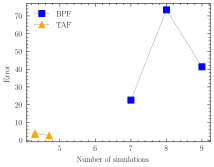

In [ ]:
plt.plot(bpf_num_sims, bpf_errors, linewidth=0.5, color='gray', markerfacecolor='blue', markeredgecolor='blue', marker='s', linestyle='--', label='BPF')
plt.plot(taf_num_sims, taf_errors, linewidth=0.5, color='gray', markerfacecolor='orange', markeredgecolor='orange', marker='^', linestyle='--', label='TAF')
plt.xlabel('Number of simulations')
# plt.xticks(jnp.linspace(0, 7, 8), [f'$10^{i}$' for i in range(8)])
plt.ylabel('Error')
plt.legend()
plt.show()